# Overfitting and regularization with gluon

In [1]:
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import gluon
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\h5py\tests\old\test_attrs_data.py:251: DeprecationWarning: invalid escape sequence \H
  s = b"Hello\x00\Hello"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\func_inspect.py:53: DeprecationWarning: invalid escape sequence \<
  '\<doctest (.*\.rst)\[(.*)\]\>', source_file).groups()
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_memory_helpers.py:10: DeprecationWarning: invalid escape sequence \s
  cookie_re = re.compile("coding[:=]\s*([-\w.]+)")


In [2]:
mx.random.seed(7)

In [3]:
# Context
ctx = mx.cpu()

## MNIST dataset

In [4]:
num_examples = 1000
batch_size = 64

In [5]:
mnist = mx.test_utils.get_mnist()
train_data = gluon.data.DataLoader(
    gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                            mnist["train_label"][:num_examples].astype(np.float32)),
    batch_size, 
    shuffle=True)

test_data = gluon.data.DataLoader(
    gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

## Multiclass Logistic Regression

In [6]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))

## Parameter initialization

In [7]:
# Xavier initialization
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), 
                                ctx=ctx)

## Softmax Cross Entropy Loss

In [8]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimizer

In [9]:
trainer = gluon.Trainer(params=net.collect_params(), 
                        optimizer='sgd', 
                        optimizer_params={'learning_rate': 0.01, 
                                          'wd': 0.0})

## Evaluation 

In [10]:
def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        output = net(data)
        loss = loss_fun(output, label)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, 
                   labels=label)
        loss_avg = loss_avg * i/(i + 1) + mx.nd.mean(loss).asscalar()/(i + 1)
    return acc.get()[1], loss_avg

## Plotting learning curves

In [11]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12, 6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch', fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True, which="both")

    fg1.legend(['training loss', 'testing loss'], 
               fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True, which="both")
    fg2.legend(['training accuracy', 'testing accuracy'], 
               fontsize=14)

## Training loop

In [12]:
epochs = 2000
moving_loss = 0.

In [13]:
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

In [14]:
for e in tqdm(range(epochs)):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with mx.autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * mx.nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1 - 0.99 ** niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


  0%|                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]

Completed epoch 1. Train Loss: 2.156003311276436, Test Loss 2.1972816884517665, Train_acc 0.225, Test_acc 0.213


  1%|█▋                                                                                                                                                                         | 20/2000 [00:01<02:24, 13.74it/s]

Completed epoch 21. Train Loss: 0.9029302559792995, Test Loss 1.1013060398399832, Train_acc 0.828, Test_acc 0.728


  2%|███▍                                                                                                                                                                       | 40/2000 [00:02<02:12, 14.82it/s]

Completed epoch 41. Train Loss: 0.6579598169773817, Test Loss 0.8702444583177567, Train_acc 0.857, Test_acc 0.773


  3%|█████                                                                                                                                                                      | 59/2000 [00:03<02:01, 16.00it/s]

Completed epoch 61. Train Loss: 0.5522979069501162, Test Loss 0.7667078785598276, Train_acc 0.88, Test_acc 0.785


  4%|██████▊                                                                                                                                                                    | 79/2000 [00:04<01:55, 16.67it/s]

Completed epoch 81. Train Loss: 0.4860010724514723, Test Loss 0.7057705074548721, Train_acc 0.892, Test_acc 0.798


  5%|████████▍                                                                                                                                                                  | 99/2000 [00:05<01:50, 17.15it/s]

Completed epoch 101. Train Loss: 0.43971441499888897, Test Loss 0.6639423370361327, Train_acc 0.901, Test_acc 0.804


  6%|██████████                                                                                                                                                                | 119/2000 [00:06<01:47, 17.47it/s]

Completed epoch 121. Train Loss: 0.4098179377615452, Test Loss 0.6339579857885839, Train_acc 0.907, Test_acc 0.808


  7%|███████████▊                                                                                                                                                              | 139/2000 [00:07<01:45, 17.68it/s]

Completed epoch 141. Train Loss: 0.3853795528411864, Test Loss 0.6105705182999372, Train_acc 0.916, Test_acc 0.811


  8%|█████████████▌                                                                                                                                                            | 159/2000 [00:08<01:42, 17.88it/s]

Completed epoch 161. Train Loss: 0.3605247978121042, Test Loss 0.5920633003115653, Train_acc 0.921, Test_acc 0.819


  9%|███████████████▏                                                                                                                                                          | 179/2000 [00:09<01:41, 18.02it/s]

Completed epoch 181. Train Loss: 0.34307374525815254, Test Loss 0.5773820020258427, Train_acc 0.924, Test_acc 0.822


 10%|████████████████▉                                                                                                                                                         | 199/2000 [00:10<01:39, 18.15it/s]

Completed epoch 201. Train Loss: 0.32921361643821007, Test Loss 0.5656476728618146, Train_acc 0.927, Test_acc 0.824


 11%|██████████████████▌                                                                                                                                                       | 219/2000 [00:12<01:37, 18.23it/s]

Completed epoch 221. Train Loss: 0.3114968156442046, Test Loss 0.555368026718497, Train_acc 0.93, Test_acc 0.826


 12%|████████████████████▎                                                                                                                                                     | 239/2000 [00:13<01:36, 18.27it/s]

Completed epoch 241. Train Loss: 0.29953410755842924, Test Loss 0.5467252712696791, Train_acc 0.933, Test_acc 0.83


 13%|██████████████████████                                                                                                                                                    | 259/2000 [00:14<01:35, 18.15it/s]

Completed epoch 261. Train Loss: 0.2899957923218608, Test Loss 0.5393272899091245, Train_acc 0.937, Test_acc 0.833


 14%|███████████████████████▋                                                                                                                                                  | 279/2000 [00:15<01:35, 18.06it/s]

Completed epoch 281. Train Loss: 0.27671477198600775, Test Loss 0.5329492818564174, Train_acc 0.941, Test_acc 0.834


 15%|█████████████████████████▍                                                                                                                                                | 299/2000 [00:16<01:34, 18.07it/s]

Completed epoch 301. Train Loss: 0.26849262323230516, Test Loss 0.5276066679507494, Train_acc 0.944, Test_acc 0.838


 16%|███████████████████████████                                                                                                                                               | 319/2000 [00:17<01:32, 18.13it/s]

Completed epoch 321. Train Loss: 0.2633694149553776, Test Loss 0.5230096485465765, Train_acc 0.945, Test_acc 0.839


 17%|████████████████████████████▊                                                                                                                                             | 339/2000 [00:18<01:31, 18.19it/s]

Completed epoch 341. Train Loss: 0.2533222669735551, Test Loss 0.5189691670238972, Train_acc 0.946, Test_acc 0.84


 18%|██████████████████████████████▌                                                                                                                                           | 359/2000 [00:19<01:29, 18.26it/s]

Completed epoch 361. Train Loss: 0.24997274577617645, Test Loss 0.5152328815311195, Train_acc 0.946, Test_acc 0.841


 19%|████████████████████████████████▏                                                                                                                                         | 379/2000 [00:20<01:28, 18.31it/s]

Completed epoch 381. Train Loss: 0.2401099018752575, Test Loss 0.5123945903033018, Train_acc 0.948, Test_acc 0.841


 20%|█████████████████████████████████▉                                                                                                                                        | 399/2000 [00:21<01:27, 18.35it/s]

Completed epoch 401. Train Loss: 0.2341016661375761, Test Loss 0.5096928738057613, Train_acc 0.95, Test_acc 0.841


 21%|███████████████████████████████████▌                                                                                                                                      | 419/2000 [00:22<01:26, 18.35it/s]

Completed epoch 421. Train Loss: 0.22672497853636742, Test Loss 0.5075052753090858, Train_acc 0.954, Test_acc 0.842


 22%|█████████████████████████████████████▎                                                                                                                                    | 439/2000 [00:23<01:24, 18.39it/s]

Completed epoch 441. Train Loss: 0.22058197204023597, Test Loss 0.505468236282468, Train_acc 0.955, Test_acc 0.843


 23%|███████████████████████████████████████                                                                                                                                   | 459/2000 [00:24<01:23, 18.42it/s]

Completed epoch 461. Train Loss: 0.21745028439909217, Test Loss 0.5031618718057871, Train_acc 0.958, Test_acc 0.845


 24%|████████████████████████████████████████▋                                                                                                                                 | 479/2000 [00:25<01:22, 18.45it/s]

Completed epoch 481. Train Loss: 0.20883949426934126, Test Loss 0.5016460623592138, Train_acc 0.959, Test_acc 0.847


 25%|██████████████████████████████████████████▍                                                                                                                               | 499/2000 [00:26<01:21, 18.48it/s]

Completed epoch 501. Train Loss: 0.20279973652213812, Test Loss 0.5003351867198942, Train_acc 0.963, Test_acc 0.844


 26%|████████████████████████████████████████████                                                                                                                              | 519/2000 [00:28<01:19, 18.51it/s]

Completed epoch 521. Train Loss: 0.19998641824349758, Test Loss 0.49908673390746117, Train_acc 0.965, Test_acc 0.844


 27%|█████████████████████████████████████████████▊                                                                                                                            | 539/2000 [00:29<01:18, 18.54it/s]

Completed epoch 541. Train Loss: 0.19384651444852352, Test Loss 0.4980953373014927, Train_acc 0.966, Test_acc 0.844


 28%|███████████████████████████████████████████████▌                                                                                                                          | 559/2000 [00:30<01:17, 18.56it/s]

Completed epoch 561. Train Loss: 0.1916306680068373, Test Loss 0.497284336015582, Train_acc 0.967, Test_acc 0.844


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 579/2000 [00:31<01:16, 18.58it/s]

Completed epoch 581. Train Loss: 0.18919563852250573, Test Loss 0.49632421135902394, Train_acc 0.968, Test_acc 0.844


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 599/2000 [00:32<01:15, 18.60it/s]

Completed epoch 601. Train Loss: 0.18199362885206938, Test Loss 0.4953685030341149, Train_acc 0.968, Test_acc 0.844


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 619/2000 [00:33<01:14, 18.62it/s]

Completed epoch 621. Train Loss: 0.18070810241624713, Test Loss 0.4952814616262913, Train_acc 0.968, Test_acc 0.843


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 639/2000 [00:34<01:13, 18.63it/s]

Completed epoch 641. Train Loss: 0.17400973755866292, Test Loss 0.49430594965815544, Train_acc 0.969, Test_acc 0.842


 33%|████████████████████████████████████████████████████████                                                                                                                  | 659/2000 [00:35<01:12, 18.60it/s]

Completed epoch 661. Train Loss: 0.170193056575954, Test Loss 0.4940799307078123, Train_acc 0.969, Test_acc 0.841


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 679/2000 [00:36<01:11, 18.59it/s]

Completed epoch 681. Train Loss: 0.16776947025209663, Test Loss 0.49388534761965275, Train_acc 0.97, Test_acc 0.841


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 699/2000 [00:37<01:10, 18.58it/s]

Completed epoch 701. Train Loss: 0.1627540197223425, Test Loss 0.4931727182120085, Train_acc 0.97, Test_acc 0.84


 36%|█████████████████████████████████████████████████████████████                                                                                                             | 719/2000 [00:38<01:08, 18.58it/s]

Completed epoch 721. Train Loss: 0.16296955337747926, Test Loss 0.4931673891842366, Train_acc 0.971, Test_acc 0.838


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 739/2000 [00:39<01:07, 18.57it/s]

Completed epoch 741. Train Loss: 0.15949946595355868, Test Loss 0.4929027911275625, Train_acc 0.971, Test_acc 0.838


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 759/2000 [00:40<01:06, 18.55it/s]

Completed epoch 761. Train Loss: 0.1544620282948017, Test Loss 0.49321942031383514, Train_acc 0.973, Test_acc 0.838


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 779/2000 [00:41<01:05, 18.55it/s]

Completed epoch 781. Train Loss: 0.15402531391009688, Test Loss 0.49269862473011017, Train_acc 0.974, Test_acc 0.838


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 799/2000 [00:43<01:04, 18.52it/s]

Completed epoch 801. Train Loss: 0.1491589145734906, Test Loss 0.49306421354413027, Train_acc 0.974, Test_acc 0.837


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                    | 819/2000 [00:44<01:03, 18.52it/s]

Completed epoch 821. Train Loss: 0.14803070342168215, Test Loss 0.4925809931010008, Train_acc 0.976, Test_acc 0.837


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                  | 839/2000 [00:45<01:02, 18.51it/s]

Completed epoch 841. Train Loss: 0.14490527426823968, Test Loss 0.49314806796610355, Train_acc 0.976, Test_acc 0.838


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 859/2000 [00:46<01:01, 18.49it/s]

Completed epoch 861. Train Loss: 0.14408211642876267, Test Loss 0.4931824132800102, Train_acc 0.976, Test_acc 0.839


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                               | 879/2000 [00:47<01:00, 18.49it/s]

Completed epoch 881. Train Loss: 0.13920452585443854, Test Loss 0.4930899944156409, Train_acc 0.976, Test_acc 0.839


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                             | 899/2000 [00:48<00:59, 18.48it/s]

Completed epoch 901. Train Loss: 0.1386759621091187, Test Loss 0.4935086201876402, Train_acc 0.977, Test_acc 0.838


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                            | 919/2000 [00:50<00:58, 18.37it/s]

Completed epoch 921. Train Loss: 0.13500246545299888, Test Loss 0.49377372302114964, Train_acc 0.977, Test_acc 0.838


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                          | 939/2000 [00:51<00:58, 18.29it/s]

Completed epoch 941. Train Loss: 0.13637939281761646, Test Loss 0.49384697526693344, Train_acc 0.978, Test_acc 0.836


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 959/2000 [00:52<00:57, 18.24it/s]

Completed epoch 961. Train Loss: 0.12996438238769767, Test Loss 0.4940812550485133, Train_acc 0.978, Test_acc 0.836


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 979/2000 [00:53<00:56, 18.20it/s]

Completed epoch 981. Train Loss: 0.12895014602690932, Test Loss 0.4946017805486918, Train_acc 0.979, Test_acc 0.836


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 999/2000 [00:54<00:55, 18.17it/s]

Completed epoch 1001. Train Loss: 0.12703457660973072, Test Loss 0.49476609565317625, Train_acc 0.979, Test_acc 0.836


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1019/2000 [00:56<00:54, 18.09it/s]

Completed epoch 1021. Train Loss: 0.1262666736729443, Test Loss 0.4950265092775226, Train_acc 0.979, Test_acc 0.834


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1039/2000 [00:57<00:53, 18.06it/s]

Completed epoch 1041. Train Loss: 0.12326891347765923, Test Loss 0.4954195143654942, Train_acc 0.981, Test_acc 0.834


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1059/2000 [00:58<00:52, 18.05it/s]

Completed epoch 1061. Train Loss: 0.12435337156057356, Test Loss 0.4955874895676971, Train_acc 0.982, Test_acc 0.833


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1079/2000 [00:59<00:51, 18.06it/s]

Completed epoch 1081. Train Loss: 0.11961637251079082, Test Loss 0.4960729070007801, Train_acc 0.982, Test_acc 0.833


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1099/2000 [01:00<00:49, 18.06it/s]

Completed epoch 1101. Train Loss: 0.1180432797409594, Test Loss 0.496289093978703, Train_acc 0.984, Test_acc 0.833


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1119/2000 [01:02<00:48, 18.05it/s]

Completed epoch 1121. Train Loss: 0.11580048082396388, Test Loss 0.49656109046190977, Train_acc 0.985, Test_acc 0.832


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1139/2000 [01:03<00:47, 18.05it/s]

Completed epoch 1141. Train Loss: 0.11410521296784282, Test Loss 0.4970168136060238, Train_acc 0.985, Test_acc 0.832


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1159/2000 [01:04<00:46, 18.06it/s]

Completed epoch 1161. Train Loss: 0.11267912480980158, Test Loss 0.4973067715764046, Train_acc 0.988, Test_acc 0.832


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1179/2000 [01:05<00:45, 18.06it/s]

Completed epoch 1181. Train Loss: 0.11174383712932467, Test Loss 0.49772804044187074, Train_acc 0.988, Test_acc 0.833


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1199/2000 [01:06<00:44, 18.06it/s]

Completed epoch 1201. Train Loss: 0.11071066837757826, Test Loss 0.49798877909779543, Train_acc 0.99, Test_acc 0.832


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1219/2000 [01:07<00:43, 18.06it/s]

Completed epoch 1221. Train Loss: 0.10801366483792663, Test Loss 0.49833506159484386, Train_acc 0.991, Test_acc 0.833


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1239/2000 [01:08<00:42, 18.06it/s]

Completed epoch 1241. Train Loss: 0.10814355034381153, Test Loss 0.4988357508555054, Train_acc 0.992, Test_acc 0.833


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1259/2000 [01:09<00:41, 18.07it/s]

Completed epoch 1261. Train Loss: 0.10453935246914624, Test Loss 0.4993227515369654, Train_acc 0.992, Test_acc 0.833


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1279/2000 [01:10<00:39, 18.07it/s]

Completed epoch 1281. Train Loss: 0.10527286445721984, Test Loss 0.4995058421045542, Train_acc 0.992, Test_acc 0.834


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1299/2000 [01:11<00:38, 18.08it/s]

Completed epoch 1301. Train Loss: 0.10207500681281088, Test Loss 0.5001825308427215, Train_acc 0.992, Test_acc 0.834


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1319/2000 [01:12<00:37, 18.08it/s]

Completed epoch 1321. Train Loss: 0.10148931993171573, Test Loss 0.5004988750442863, Train_acc 0.992, Test_acc 0.834


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1339/2000 [01:14<00:36, 18.07it/s]

Completed epoch 1341. Train Loss: 0.10030154651030898, Test Loss 0.5009833285585046, Train_acc 0.992, Test_acc 0.834


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1359/2000 [01:15<00:35, 18.07it/s]

Completed epoch 1361. Train Loss: 0.09826570539735256, Test Loss 0.5013389233499765, Train_acc 0.993, Test_acc 0.836


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1379/2000 [01:16<00:34, 18.08it/s]

Completed epoch 1381. Train Loss: 0.09766348893754184, Test Loss 0.5017631752416492, Train_acc 0.994, Test_acc 0.837


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1399/2000 [01:17<00:33, 18.08it/s]

Completed epoch 1401. Train Loss: 0.0959677565842867, Test Loss 0.5019104648381472, Train_acc 0.994, Test_acc 0.836


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1419/2000 [01:18<00:32, 18.04it/s]

Completed epoch 1421. Train Loss: 0.09525813371874392, Test Loss 0.5024041449651122, Train_acc 0.995, Test_acc 0.836


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1439/2000 [01:20<00:31, 17.95it/s]

Completed epoch 1441. Train Loss: 0.09410022664815186, Test Loss 0.5030829077586532, Train_acc 0.995, Test_acc 0.836


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1459/2000 [01:21<00:30, 17.92it/s]

Completed epoch 1461. Train Loss: 0.09250186081044376, Test Loss 0.5036012176424265, Train_acc 0.995, Test_acc 0.836


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1479/2000 [01:22<00:29, 17.86it/s]

Completed epoch 1481. Train Loss: 0.09204664756543934, Test Loss 0.5039361417293551, Train_acc 0.995, Test_acc 0.836


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1499/2000 [01:23<00:28, 17.85it/s]

Completed epoch 1501. Train Loss: 0.09117402182891964, Test Loss 0.5045732436701655, Train_acc 0.996, Test_acc 0.836


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1519/2000 [01:25<00:26, 17.85it/s]

Completed epoch 1521. Train Loss: 0.08948700409382582, Test Loss 0.5048098815605044, Train_acc 0.997, Test_acc 0.836


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1539/2000 [01:26<00:25, 17.85it/s]

Completed epoch 1541. Train Loss: 0.08789376961067319, Test Loss 0.5052803484722972, Train_acc 0.997, Test_acc 0.837


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1559/2000 [01:27<00:24, 17.86it/s]

Completed epoch 1561. Train Loss: 0.08842963911592962, Test Loss 0.5057781608775258, Train_acc 0.998, Test_acc 0.837


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1579/2000 [01:28<00:23, 17.85it/s]

Completed epoch 1581. Train Loss: 0.08658725186251104, Test Loss 0.5064848307520151, Train_acc 0.998, Test_acc 0.835


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1599/2000 [01:29<00:22, 17.86it/s]

Completed epoch 1601. Train Loss: 0.08578502293676138, Test Loss 0.506609813310206, Train_acc 0.998, Test_acc 0.838


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1619/2000 [01:30<00:21, 17.87it/s]

Completed epoch 1621. Train Loss: 0.08464896003715693, Test Loss 0.5070937117561698, Train_acc 0.998, Test_acc 0.835


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1639/2000 [01:31<00:20, 17.87it/s]

Completed epoch 1641. Train Loss: 0.08362658973783255, Test Loss 0.5075140437111259, Train_acc 0.998, Test_acc 0.835


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1659/2000 [01:32<00:19, 17.88it/s]

Completed epoch 1661. Train Loss: 0.08225017390213905, Test Loss 0.5078701544553041, Train_acc 0.998, Test_acc 0.835


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1679/2000 [01:33<00:17, 17.88it/s]

Completed epoch 1681. Train Loss: 0.08144469815306365, Test Loss 0.5084378952160478, Train_acc 0.998, Test_acc 0.836


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1699/2000 [01:34<00:16, 17.88it/s]

Completed epoch 1701. Train Loss: 0.08037286694161597, Test Loss 0.5087252613157035, Train_acc 0.998, Test_acc 0.835


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1719/2000 [01:36<00:15, 17.89it/s]

Completed epoch 1721. Train Loss: 0.08140003029257059, Test Loss 0.5090499324724078, Train_acc 0.998, Test_acc 0.836


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1739/2000 [01:37<00:14, 17.89it/s]

Completed epoch 1741. Train Loss: 0.07987128687091172, Test Loss 0.5094940839335322, Train_acc 0.998, Test_acc 0.836


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1759/2000 [01:38<00:13, 17.90it/s]

Completed epoch 1761. Train Loss: 0.07776780496351421, Test Loss 0.5101453838869929, Train_acc 0.998, Test_acc 0.837


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1779/2000 [01:39<00:12, 17.90it/s]

Completed epoch 1781. Train Loss: 0.07775869825854897, Test Loss 0.510568818077445, Train_acc 0.998, Test_acc 0.837


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1799/2000 [01:40<00:11, 17.91it/s]

Completed epoch 1801. Train Loss: 0.07651890465058388, Test Loss 0.5108481720089912, Train_acc 0.998, Test_acc 0.835


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1819/2000 [01:41<00:10, 17.91it/s]

Completed epoch 1821. Train Loss: 0.0766520882025361, Test Loss 0.5112976068630815, Train_acc 0.998, Test_acc 0.836


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1839/2000 [01:42<00:08, 17.92it/s]

Completed epoch 1841. Train Loss: 0.07574669062159956, Test Loss 0.5119076818227768, Train_acc 0.998, Test_acc 0.836


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1859/2000 [01:43<00:07, 17.92it/s]

Completed epoch 1861. Train Loss: 0.07544511067681016, Test Loss 0.5122226653620601, Train_acc 0.998, Test_acc 0.836


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1879/2000 [01:44<00:06, 17.92it/s]

Completed epoch 1881. Train Loss: 0.07478393893688916, Test Loss 0.5128104239702226, Train_acc 0.998, Test_acc 0.837


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1899/2000 [01:45<00:05, 17.93it/s]

Completed epoch 1901. Train Loss: 0.07243553432635963, Test Loss 0.5131997959688306, Train_acc 0.998, Test_acc 0.836


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1919/2000 [01:47<00:04, 17.93it/s]

Completed epoch 1921. Train Loss: 0.07236896152608098, Test Loss 0.5136037245392799, Train_acc 0.998, Test_acc 0.836


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1939/2000 [01:48<00:03, 17.93it/s]

Completed epoch 1941. Train Loss: 0.07200061529874802, Test Loss 0.5140862325206399, Train_acc 0.998, Test_acc 0.835


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1959/2000 [01:49<00:02, 17.94it/s]

Completed epoch 1961. Train Loss: 0.07068506930954754, Test Loss 0.5144887520000339, Train_acc 0.998, Test_acc 0.835


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1979/2000 [01:50<00:01, 17.94it/s]

Completed epoch 1981. Train Loss: 0.06948715890757741, Test Loss 0.5149267399683595, Train_acc 0.998, Test_acc 0.835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 17.94it/s]


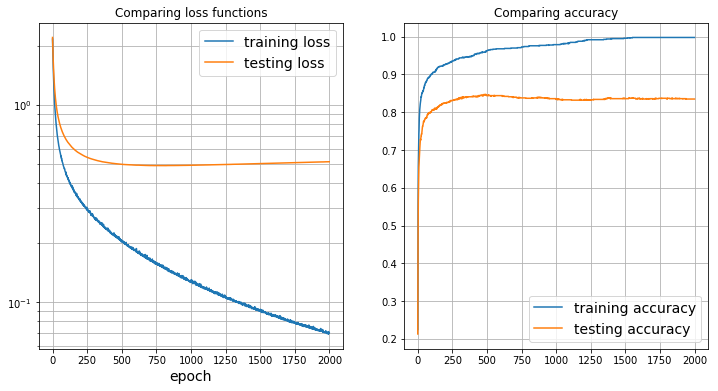

In [15]:
## Plotting the learning curves
plot_learningcurves(loss_seq_train, loss_seq_test, acc_seq_train, acc_seq_test)

In [16]:
acc_seq_test[-1]

0.835

## Regularization

In [17]:
# Resetting the parameters
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)

In [18]:
# L2 regularization is obtained by setting optmizer parameter 'wd' = (weight decay) to a non-zero value
trainer = gluon.Trainer(params=net.collect_params(), 
                        optimizer='sgd', 
                        optimizer_params={'learning_rate': 0.01, 'wd': 0.01})

## Re-training

In [19]:
moving_loss = 0.
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

In [20]:
for e in tqdm(range(epochs)):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with mx.autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * mx.nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1 - 0.99 ** niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


  0%|                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]

Completed epoch 1. Train Loss: 2.089402586221695, Test Loss 2.1451647579669952, Train_acc 0.363, Test_acc 0.311


  1%|█▋                                                                                                                                                                         | 20/2000 [00:01<01:53, 17.40it/s]

Completed epoch 21. Train Loss: 0.9033627845346928, Test Loss 1.1068353950977325, Train_acc 0.835, Test_acc 0.716


  2%|███▍                                                                                                                                                                       | 40/2000 [00:02<01:52, 17.47it/s]

Completed epoch 41. Train Loss: 0.6701639145612717, Test Loss 0.8869900181889534, Train_acc 0.864, Test_acc 0.753


  3%|█████▏                                                                                                                                                                     | 60/2000 [00:03<01:49, 17.65it/s]

Completed epoch 61. Train Loss: 0.5694266017526389, Test Loss 0.7881941497325896, Train_acc 0.877, Test_acc 0.779


  4%|██████▊                                                                                                                                                                    | 80/2000 [00:04<01:47, 17.79it/s]

Completed epoch 81. Train Loss: 0.5141889210790396, Test Loss 0.7306451499462128, Train_acc 0.891, Test_acc 0.799


  5%|████████▌                                                                                                                                                                 | 100/2000 [00:05<01:46, 17.88it/s]

Completed epoch 101. Train Loss: 0.46908548474311823, Test Loss 0.6920170821249485, Train_acc 0.897, Test_acc 0.805


  6%|██████████▏                                                                                                                                                               | 120/2000 [00:06<01:45, 17.90it/s]

Completed epoch 121. Train Loss: 0.4418474398553371, Test Loss 0.6639201007783413, Train_acc 0.902, Test_acc 0.809


  7%|███████████▉                                                                                                                                                              | 140/2000 [00:07<01:43, 17.94it/s]

Completed epoch 141. Train Loss: 0.41956429928541183, Test Loss 0.6437448542565106, Train_acc 0.908, Test_acc 0.817


  8%|█████████████▌                                                                                                                                                            | 160/2000 [00:08<01:42, 17.99it/s]

Completed epoch 161. Train Loss: 0.4018951263278723, Test Loss 0.6274194847792388, Train_acc 0.915, Test_acc 0.821


  9%|███████████████▎                                                                                                                                                          | 180/2000 [00:10<01:41, 18.00it/s]

Completed epoch 181. Train Loss: 0.38432133756577974, Test Loss 0.6148747205734253, Train_acc 0.92, Test_acc 0.822


 10%|█████████████████                                                                                                                                                         | 200/2000 [00:11<01:39, 18.02it/s]

Completed epoch 201. Train Loss: 0.3719477634876966, Test Loss 0.6046707183122636, Train_acc 0.92, Test_acc 0.824


 11%|██████████████████▋                                                                                                                                                       | 220/2000 [00:12<01:38, 18.03it/s]

Completed epoch 221. Train Loss: 0.3619706071913243, Test Loss 0.5962419826537372, Train_acc 0.926, Test_acc 0.825


 12%|████████████████████▍                                                                                                                                                     | 240/2000 [00:13<01:37, 18.05it/s]

Completed epoch 241. Train Loss: 0.3530365545302629, Test Loss 0.5890898145735264, Train_acc 0.927, Test_acc 0.829


 13%|██████████████████████                                                                                                                                                    | 260/2000 [00:14<01:36, 18.08it/s]

Completed epoch 261. Train Loss: 0.3437678497284651, Test Loss 0.5838981289416552, Train_acc 0.93, Test_acc 0.829


 14%|███████████████████████▊                                                                                                                                                  | 280/2000 [00:15<01:35, 18.10it/s]

Completed epoch 281. Train Loss: 0.3349156165495515, Test Loss 0.5788454618304968, Train_acc 0.931, Test_acc 0.83


 15%|█████████████████████████▌                                                                                                                                                | 300/2000 [00:16<01:33, 18.10it/s]

Completed epoch 301. Train Loss: 0.3281224584206939, Test Loss 0.5749717932194471, Train_acc 0.935, Test_acc 0.834


 16%|███████████████████████████▏                                                                                                                                              | 320/2000 [00:17<01:32, 18.12it/s]

Completed epoch 321. Train Loss: 0.32351891137659544, Test Loss 0.5714136306196451, Train_acc 0.938, Test_acc 0.834


 17%|████████████████████████████▉                                                                                                                                             | 340/2000 [00:18<01:31, 18.12it/s]

Completed epoch 341. Train Loss: 0.31955052353441715, Test Loss 0.5683435127139091, Train_acc 0.94, Test_acc 0.836


 18%|██████████████████████████████▌                                                                                                                                           | 360/2000 [00:19<01:30, 18.07it/s]

Completed epoch 361. Train Loss: 0.3148710187524557, Test Loss 0.5658237282186745, Train_acc 0.942, Test_acc 0.836


 19%|████████████████████████████████▎                                                                                                                                         | 380/2000 [00:21<01:30, 17.98it/s]

Completed epoch 381. Train Loss: 0.3096587108448146, Test Loss 0.5632725097239017, Train_acc 0.943, Test_acc 0.834


 20%|██████████████████████████████████                                                                                                                                        | 400/2000 [00:22<01:29, 17.97it/s]

Completed epoch 401. Train Loss: 0.30855078529566526, Test Loss 0.5610936731100082, Train_acc 0.944, Test_acc 0.835


 21%|███████████████████████████████████▋                                                                                                                                      | 420/2000 [00:23<01:27, 17.98it/s]

Completed epoch 421. Train Loss: 0.3052110876888037, Test Loss 0.5596411619335412, Train_acc 0.944, Test_acc 0.836


 22%|█████████████████████████████████████▍                                                                                                                                    | 440/2000 [00:24<01:26, 17.99it/s]

Completed epoch 441. Train Loss: 0.2995504001155495, Test Loss 0.5578847415745259, Train_acc 0.944, Test_acc 0.84


 23%|███████████████████████████████████████                                                                                                                                   | 460/2000 [00:25<01:25, 18.00it/s]

Completed epoch 461. Train Loss: 0.29712524637579923, Test Loss 0.5562486350536346, Train_acc 0.946, Test_acc 0.842


 24%|████████████████████████████████████████▊                                                                                                                                 | 480/2000 [00:26<01:24, 17.90it/s]

Completed epoch 481. Train Loss: 0.29422081634402275, Test Loss 0.5547662638127806, Train_acc 0.949, Test_acc 0.842


 25%|██████████████████████████████████████████▌                                                                                                                               | 500/2000 [00:27<01:23, 17.90it/s]

Completed epoch 501. Train Loss: 0.2917476762086153, Test Loss 0.5536565892398355, Train_acc 0.949, Test_acc 0.842


 26%|████████████████████████████████████████████▏                                                                                                                             | 520/2000 [00:29<01:22, 17.88it/s]

Completed epoch 521. Train Loss: 0.2898259209468962, Test Loss 0.5530604980885984, Train_acc 0.951, Test_acc 0.842


 27%|█████████████████████████████████████████████▉                                                                                                                            | 540/2000 [00:30<01:21, 17.84it/s]

Completed epoch 541. Train Loss: 0.28687509521842003, Test Loss 0.5518665462732314, Train_acc 0.951, Test_acc 0.841


 28%|███████████████████████████████████████████████▌                                                                                                                          | 560/2000 [00:31<01:20, 17.83it/s]

Completed epoch 561. Train Loss: 0.28677516710013146, Test Loss 0.5511928405612705, Train_acc 0.952, Test_acc 0.842


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 580/2000 [00:32<01:19, 17.84it/s]

Completed epoch 581. Train Loss: 0.2871344340965152, Test Loss 0.5504220034927129, Train_acc 0.952, Test_acc 0.842


 30%|███████████████████████████████████████████████████                                                                                                                       | 600/2000 [00:33<01:18, 17.85it/s]

Completed epoch 601. Train Loss: 0.28111226111650467, Test Loss 0.5497533418238162, Train_acc 0.953, Test_acc 0.842


 31%|████████████████████████████████████████████████████▋                                                                                                                     | 620/2000 [00:34<01:17, 17.86it/s]

Completed epoch 621. Train Loss: 0.27915502060204744, Test Loss 0.5492118392139672, Train_acc 0.955, Test_acc 0.841


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 640/2000 [00:35<01:16, 17.87it/s]

Completed epoch 641. Train Loss: 0.27718170918524265, Test Loss 0.5488934218883514, Train_acc 0.954, Test_acc 0.842


 33%|████████████████████████████████████████████████████████                                                                                                                  | 660/2000 [00:36<01:14, 17.88it/s]

Completed epoch 661. Train Loss: 0.2782572340220213, Test Loss 0.5487343017011881, Train_acc 0.955, Test_acc 0.843


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 680/2000 [00:38<01:13, 17.89it/s]

Completed epoch 681. Train Loss: 0.2753404062241316, Test Loss 0.5477210506796836, Train_acc 0.956, Test_acc 0.842


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 700/2000 [00:39<01:12, 17.90it/s]

Completed epoch 701. Train Loss: 0.27663394715636963, Test Loss 0.5475168768316507, Train_acc 0.957, Test_acc 0.843


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 720/2000 [00:40<01:11, 17.90it/s]

Completed epoch 721. Train Loss: 0.2725710067898035, Test Loss 0.5472312960773706, Train_acc 0.957, Test_acc 0.843


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 740/2000 [00:41<01:10, 17.90it/s]

Completed epoch 741. Train Loss: 0.2722343904897571, Test Loss 0.5466654244810343, Train_acc 0.958, Test_acc 0.845


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 760/2000 [00:42<01:09, 17.91it/s]

Completed epoch 761. Train Loss: 0.2738494062796235, Test Loss 0.5467446651309729, Train_acc 0.959, Test_acc 0.846


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 780/2000 [00:43<01:08, 17.92it/s]

Completed epoch 781. Train Loss: 0.27059729024767876, Test Loss 0.5463098157197235, Train_acc 0.958, Test_acc 0.846


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 800/2000 [00:44<01:06, 17.93it/s]

Completed epoch 801. Train Loss: 0.271795733831823, Test Loss 0.5462036207318305, Train_acc 0.959, Test_acc 0.847


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 820/2000 [00:45<01:05, 17.93it/s]

Completed epoch 821. Train Loss: 0.2678649518638849, Test Loss 0.5461566559970379, Train_acc 0.958, Test_acc 0.847


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 840/2000 [00:46<01:04, 17.93it/s]

Completed epoch 841. Train Loss: 0.26878249272704124, Test Loss 0.5456131510436535, Train_acc 0.958, Test_acc 0.847


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 860/2000 [00:47<01:03, 17.93it/s]

Completed epoch 861. Train Loss: 0.27125472109764825, Test Loss 0.5456712003797293, Train_acc 0.959, Test_acc 0.846


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 880/2000 [00:49<01:02, 17.94it/s]

Completed epoch 881. Train Loss: 0.27029919438064093, Test Loss 0.5455346684902908, Train_acc 0.959, Test_acc 0.846


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 900/2000 [00:50<01:01, 17.94it/s]

Completed epoch 901. Train Loss: 0.2686413982883095, Test Loss 0.5451801382005215, Train_acc 0.959, Test_acc 0.846


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 920/2000 [00:51<01:00, 17.92it/s]

Completed epoch 921. Train Loss: 0.2658957922831178, Test Loss 0.5453348457813263, Train_acc 0.959, Test_acc 0.846


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 940/2000 [00:52<00:59, 17.92it/s]

Completed epoch 941. Train Loss: 0.2653296831995249, Test Loss 0.5453596208244562, Train_acc 0.96, Test_acc 0.846


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 960/2000 [00:53<00:57, 17.93it/s]

Completed epoch 961. Train Loss: 0.2632403178140522, Test Loss 0.5454482119530438, Train_acc 0.961, Test_acc 0.846


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 980/2000 [00:54<00:56, 17.94it/s]

Completed epoch 981. Train Loss: 0.26292363926768303, Test Loss 0.5451901257038115, Train_acc 0.961, Test_acc 0.845


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1000/2000 [00:55<00:55, 17.94it/s]

Completed epoch 1001. Train Loss: 0.2642670888453722, Test Loss 0.544977093115449, Train_acc 0.961, Test_acc 0.847


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1020/2000 [00:56<00:54, 17.93it/s]

Completed epoch 1021. Train Loss: 0.264224149286747, Test Loss 0.5448413658887148, Train_acc 0.96, Test_acc 0.846


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1040/2000 [00:58<00:53, 17.88it/s]

Completed epoch 1041. Train Loss: 0.2630877131596207, Test Loss 0.5448480155318974, Train_acc 0.96, Test_acc 0.845


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1060/2000 [00:59<00:52, 17.85it/s]

Completed epoch 1061. Train Loss: 0.26310239639133215, Test Loss 0.5446436926722527, Train_acc 0.96, Test_acc 0.845


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1080/2000 [01:00<00:51, 17.85it/s]

Completed epoch 1081. Train Loss: 0.26249055936932564, Test Loss 0.5444443486630917, Train_acc 0.961, Test_acc 0.845


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1100/2000 [01:01<00:50, 17.85it/s]

Completed epoch 1101. Train Loss: 0.2649608161300421, Test Loss 0.5442993193864823, Train_acc 0.962, Test_acc 0.846


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1120/2000 [01:02<00:49, 17.85it/s]

Completed epoch 1121. Train Loss: 0.26019141264259815, Test Loss 0.5442228633910419, Train_acc 0.96, Test_acc 0.846


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1140/2000 [01:03<00:48, 17.85it/s]

Completed epoch 1141. Train Loss: 0.26073987502604734, Test Loss 0.5441948305815458, Train_acc 0.961, Test_acc 0.847


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1160/2000 [01:05<00:47, 17.82it/s]

Completed epoch 1161. Train Loss: 0.26289178244769573, Test Loss 0.5441067460924387, Train_acc 0.962, Test_acc 0.846


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1179/2000 [01:06<00:46, 17.84it/s]

Completed epoch 1181. Train Loss: 0.2617108002305031, Test Loss 0.5442456807941197, Train_acc 0.962, Test_acc 0.845


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1199/2000 [01:07<00:44, 17.85it/s]

Completed epoch 1201. Train Loss: 0.2606465835124254, Test Loss 0.5441991910338402, Train_acc 0.962, Test_acc 0.845


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1219/2000 [01:08<00:43, 17.78it/s]

Completed epoch 1221. Train Loss: 0.2607468254864216, Test Loss 0.5441034622490406, Train_acc 0.962, Test_acc 0.846


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1239/2000 [01:09<00:42, 17.75it/s]

Completed epoch 1241. Train Loss: 0.2605006080120802, Test Loss 0.5442027971148492, Train_acc 0.962, Test_acc 0.845


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1259/2000 [01:11<00:41, 17.70it/s]

Completed epoch 1261. Train Loss: 0.2596787745133043, Test Loss 0.5442947763949634, Train_acc 0.962, Test_acc 0.847


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1279/2000 [01:12<00:40, 17.70it/s]

Completed epoch 1281. Train Loss: 0.2605927484109998, Test Loss 0.5444400627166033, Train_acc 0.962, Test_acc 0.845


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1299/2000 [01:13<00:39, 17.68it/s]

Completed epoch 1301. Train Loss: 0.2580259973183274, Test Loss 0.5442415270954372, Train_acc 0.962, Test_acc 0.845


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1319/2000 [01:14<00:38, 17.67it/s]

Completed epoch 1321. Train Loss: 0.2601652992889284, Test Loss 0.5443354025483131, Train_acc 0.962, Test_acc 0.845


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1339/2000 [01:15<00:37, 17.68it/s]

Completed epoch 1341. Train Loss: 0.2563327867537737, Test Loss 0.5440916456282139, Train_acc 0.962, Test_acc 0.845


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1359/2000 [01:16<00:36, 17.68it/s]

Completed epoch 1361. Train Loss: 0.2599731395021081, Test Loss 0.543717809021473, Train_acc 0.961, Test_acc 0.845


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1379/2000 [01:18<00:35, 17.64it/s]

Completed epoch 1381. Train Loss: 0.2611776040866971, Test Loss 0.5442032068967819, Train_acc 0.962, Test_acc 0.845


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1399/2000 [01:19<00:34, 17.64it/s]

Completed epoch 1401. Train Loss: 0.25685176067054266, Test Loss 0.5438167247921228, Train_acc 0.962, Test_acc 0.846


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1419/2000 [01:20<00:32, 17.61it/s]

Completed epoch 1421. Train Loss: 0.25715439207851887, Test Loss 0.5439440272748473, Train_acc 0.962, Test_acc 0.845


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1439/2000 [01:21<00:31, 17.63it/s]

Completed epoch 1441. Train Loss: 0.2573301699012518, Test Loss 0.5439662579447032, Train_acc 0.962, Test_acc 0.845


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1459/2000 [01:22<00:30, 17.62it/s]

Completed epoch 1461. Train Loss: 0.25831152126193047, Test Loss 0.5438033305108547, Train_acc 0.962, Test_acc 0.845


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1479/2000 [01:23<00:29, 17.62it/s]

Completed epoch 1481. Train Loss: 0.259926812723279, Test Loss 0.5436942446976901, Train_acc 0.962, Test_acc 0.845


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1499/2000 [01:25<00:28, 17.63it/s]

Completed epoch 1501. Train Loss: 0.258403361774981, Test Loss 0.5435972455888987, Train_acc 0.962, Test_acc 0.846


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1519/2000 [01:26<00:27, 17.58it/s]

Completed epoch 1521. Train Loss: 0.2562059992924332, Test Loss 0.5437814071774483, Train_acc 0.962, Test_acc 0.846


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1539/2000 [01:27<00:26, 17.52it/s]

Completed epoch 1541. Train Loss: 0.2573328949511051, Test Loss 0.543742209672928, Train_acc 0.962, Test_acc 0.845


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1559/2000 [01:29<00:25, 17.47it/s]

Completed epoch 1561. Train Loss: 0.25505932606756687, Test Loss 0.5438605714589357, Train_acc 0.962, Test_acc 0.845


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1579/2000 [01:30<00:24, 17.48it/s]

Completed epoch 1581. Train Loss: 0.2558815497905016, Test Loss 0.5439052674919367, Train_acc 0.962, Test_acc 0.846


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1600/2000 [01:31<00:22, 17.49it/s]

Completed epoch 1601. Train Loss: 0.2591149630025029, Test Loss 0.5439635515213015, Train_acc 0.962, Test_acc 0.846


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1620/2000 [01:32<00:21, 17.48it/s]

Completed epoch 1621. Train Loss: 0.25869485829025507, Test Loss 0.5438804067671298, Train_acc 0.962, Test_acc 0.845


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1640/2000 [01:33<00:20, 17.47it/s]

Completed epoch 1641. Train Loss: 0.2577542318031191, Test Loss 0.5439691115170717, Train_acc 0.963, Test_acc 0.845


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1660/2000 [01:35<00:19, 17.47it/s]

Completed epoch 1661. Train Loss: 0.25681167002767336, Test Loss 0.5435997657477856, Train_acc 0.963, Test_acc 0.845


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1680/2000 [01:36<00:18, 17.46it/s]

Completed epoch 1681. Train Loss: 0.2571635879576206, Test Loss 0.5438939947634935, Train_acc 0.963, Test_acc 0.845


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1700/2000 [01:37<00:17, 17.48it/s]

Completed epoch 1701. Train Loss: 0.25679952464997774, Test Loss 0.5437077973037957, Train_acc 0.963, Test_acc 0.845


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1719/2000 [01:38<00:16, 17.48it/s]

Completed epoch 1721. Train Loss: 0.25603797379881144, Test Loss 0.5438671782612801, Train_acc 0.962, Test_acc 0.845


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1739/2000 [01:39<00:14, 17.45it/s]

Completed epoch 1741. Train Loss: 0.25768790021538734, Test Loss 0.5438897609710694, Train_acc 0.963, Test_acc 0.845


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1759/2000 [01:40<00:13, 17.44it/s]

Completed epoch 1761. Train Loss: 0.25912748184055084, Test Loss 0.5440132971853018, Train_acc 0.963, Test_acc 0.845


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1780/2000 [01:41<00:12, 17.46it/s]

Completed epoch 1781. Train Loss: 0.2576150093227625, Test Loss 0.5440914481878281, Train_acc 0.963, Test_acc 0.845


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1799/2000 [01:42<00:11, 17.47it/s]

Completed epoch 1801. Train Loss: 0.25844801962375635, Test Loss 0.5441595781594516, Train_acc 0.963, Test_acc 0.845


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1820/2000 [01:44<00:10, 17.49it/s]

Completed epoch 1821. Train Loss: 0.25479064136743546, Test Loss 0.5440537948161364, Train_acc 0.963, Test_acc 0.845


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1840/2000 [01:45<00:09, 17.50it/s]

Completed epoch 1841. Train Loss: 0.25441150087863207, Test Loss 0.5438904985785485, Train_acc 0.963, Test_acc 0.845


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1860/2000 [01:46<00:08, 17.50it/s]

Completed epoch 1861. Train Loss: 0.2554428530856967, Test Loss 0.5438816025853157, Train_acc 0.963, Test_acc 0.845


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1880/2000 [01:47<00:06, 17.51it/s]

Completed epoch 1881. Train Loss: 0.2555305436253547, Test Loss 0.5439930576831103, Train_acc 0.963, Test_acc 0.845


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1899/2000 [01:48<00:05, 17.52it/s]

Completed epoch 1901. Train Loss: 0.2552434718236327, Test Loss 0.5437949225306511, Train_acc 0.963, Test_acc 0.846


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1919/2000 [01:49<00:04, 17.50it/s]

Completed epoch 1921. Train Loss: 0.25853300001472235, Test Loss 0.5436818581074476, Train_acc 0.963, Test_acc 0.845


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1939/2000 [01:50<00:03, 17.50it/s]

Completed epoch 1941. Train Loss: 0.2565741706639528, Test Loss 0.5435385648161173, Train_acc 0.963, Test_acc 0.845


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1959/2000 [01:51<00:02, 17.51it/s]

Completed epoch 1961. Train Loss: 0.2563193738460541, Test Loss 0.5438362807035446, Train_acc 0.963, Test_acc 0.845


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1979/2000 [01:53<00:01, 17.51it/s]

Completed epoch 1981. Train Loss: 0.2553126877173781, Test Loss 0.5437225103378296, Train_acc 0.964, Test_acc 0.844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:54<00:00, 17.52it/s]


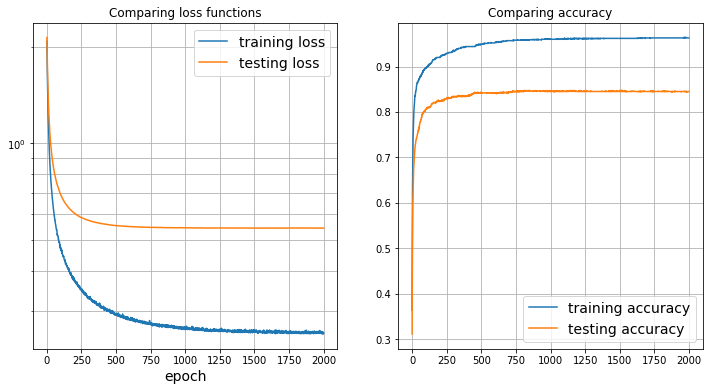

In [21]:
## Plotting the learning curves
plot_learningcurves(loss_seq_train, loss_seq_test, acc_seq_train, acc_seq_test)

In [22]:
acc_seq_test[-1]

0.845